In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, avg, unix_timestamp, dayofmonth, dayofweek, hour, col, weekofyear, round, desc
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt

In [7]:
spark = SparkSession.builder \
    .appName('NYC Taxi traffic analysis') \
    .getOrCreate()

In [8]:
df = spark.read.format("parquet").load("gs://pyspark-tutorial-mariia/data/NYC/*.parquet")

In [9]:
df.head()

Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2021, 10, 1, 0, 25, 56), tpep_dropoff_datetime=datetime.datetime(2021, 10, 1, 1, 11, 35), passenger_count=1.0, trip_distance=7.4, RatecodeID=1.0, store_and_fwd_flag='Y', PULocationID=140, DOLocationID=36, payment_type=1, fare_amount=33.0, extra=3.0, mta_tax=0.5, tip_amount=4.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=40.8, congestion_surcharge=2.5, airport_fee=0.0)

In [10]:
df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, RatecodeID: string, store_and_fwd_flag: string, PULocationID: string, DOLocationID: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string, congestion_surcharge: string, airport_fee: string]

In [5]:
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# Trip analysis

## 1
Average duration and distance of rides: Compare these metrics by time of day, day of week,
and month of year. This can reveal patterns such as longer trips during rush hours, on
weekends, or during holiday seasons.

- month: trip are becoming longer from to the end of the year, 14 min in average in January and 17 min in December.
- day: no dinamic in trip duration over the days in month. 
- hour: the longest trips from 14 to 16 hour may be because of the traffic.

In [12]:
df_enriched = df.withColumn(
        "duration_time_in_minutes",
        (
            unix_timestamp(df["tpep_dropoff_datetime"])
            - unix_timestamp(df["tpep_pickup_datetime"])
        )
        / 60,
    )

In [16]:
df_month = df_enriched.groupBy(
    month("tpep_pickup_datetime").alias("month")).agg(
    avg("duration_time_in_minutes").alias("average_trip_time_in_minutes")
).orderBy("month", ascending=True) \

df_month.show()

df_day = df_enriched.groupBy(
    dayofmonth("tpep_pickup_datetime").alias("dayofmonth")).agg(
    avg("duration_time_in_minutes").alias("average_trip_time_in_minutes")
).orderBy("dayofmonth", ascending=True)

df_day.show()

df_hour = df_enriched.groupBy(
    hour("tpep_pickup_datetime").alias("hour")).agg(
    avg("duration_time_in_minutes").alias("average_trip_time_in_minutes")
).orderBy("hour", ascending=True)

df_hour.show()

+-----+----------------------------+
|month|average_trip_time_in_minutes|
+-----+----------------------------+
|    1|           13.96193699677802|
|    2|          14.886453315993348|
|    3|          14.730989737679693|
|    4|          15.510014296137564|
|    5|          15.906733275470684|
|    6|           16.82647779882308|
|    7|          16.624542030505168|
|    8|          16.572784095643396|
|    9|           17.50014227893857|
|   10|           17.42019869197356|
|   11|           17.83479951080372|
|   12|          17.450098898736478|
+-----+----------------------------+



+----------+----------------------------+
|dayofmonth|average_trip_time_in_minutes|
+----------+----------------------------+
|         1|          16.870031700361853|
|         2|          16.638503578557465|
|         3|          16.814805932609428|
|         4|          16.634436068423792|
|         5|          16.471851994600097|
|         6|           16.30304860009416|
|         7|          16.899675057319985|
|         8|          16.748068462688625|
|         9|           16.86615200916386|
|        10|          16.966997906493408|
|        11|           16.35658159231415|
|        12|           16.65966323130641|
|        13|           16.42042025262189|
|        14|          16.530610045065423|
|        15|           16.60998932527677|
|        16|           16.51673333740257|
|        17|          16.755362833144805|
|        18|          16.453700421957578|
|        19|          16.286643447453333|
|        20|          16.502407285296506|
+----------+----------------------

+----+----------------------------+
|hour|average_trip_time_in_minutes|
+----+----------------------------+
|   0|          15.730267774016323|
|   1|           15.85016262306615|
|   2|          14.827951157969911|
|   3|          15.549170610945076|
|   4|           16.76969686715933|
|   5|           16.75420894806284|
|   6|           16.47000700343771|
|   7|          16.430668381762416|
|   8|          15.924119026266679|
|   9|          15.937159524944105|
|  10|          15.968707707678956|
|  11|          15.990086114978126|
|  12|           16.55021028658399|
|  13|          16.928557399414206|
|  14|           18.00871055110002|
|  15|           18.79831198858267|
|  16|          18.979807123045706|
|  17|          17.867833479002414|
|  18|          16.217714356261705|
|  19|          15.191404564765545|
+----+----------------------------+
only showing top 20 rows



## 2
Popular locations: Identify the top 10 pickup and dropoff locations. This could be interesting
when mapped visually.

In [15]:
# Top 10 pickup locations
df_pickup_locations = df_enriched.groupBy("PULocationID").count().orderBy(desc("count")).limit(10)

df_pickup_locations.show()

+------------+-------+
|PULocationID|  count|
+------------+-------+
|         237|1553554|
|         236|1424614|
|         161|1091329|
|         132|1025063|
|         186|1019650|
|         142| 989927|
|         170| 967766|
|         162| 954917|
|         239| 932473|
|         141| 909845|
+------------+-------+



In [27]:
# Top 10 dropoff locations
df_dropoff_locations = df_enriched.groupBy("DOLocationID").count().orderBy(desc("count")).limit(10)

df_dropoff_locations.show()

+------------+-------+
|DOLocationID|  count|
+------------+-------+
|         236|1434919|
|         237|1356518|
|         161|1001077|
|         170| 920433|
|         141| 902052|
|         239| 886837|
|         142| 854324|
|          48| 782803|
|         238| 779046|
|         162| 772823|
+------------+-------+



# Tip analysis

In [45]:
df_enriched = df.withColumn(
    "tip_percentage",
    (
        df["tip_amount"] / df["total_amount"]
    ) * 100,
)


## 1
Tip percentage by trip: Do some locations tip more than others? Is there a correlation between
distance and tip?

In [46]:
df_location = df_enriched.groupBy("PULocationID").agg(
        avg("tip_percentage").alias("average_tip_percentage")
    ).orderBy("average_tip_percentage", ascending=False) 

df_location.head(10)

[Row(PULocationID=255, average_tip_percentage=13.02283829717162),
 Row(PULocationID=249, average_tip_percentage=12.950151760560603),
 Row(PULocationID=158, average_tip_percentage=12.86750984643194),
 Row(PULocationID=199, average_tip_percentage=12.681086193114426),
 Row(PULocationID=125, average_tip_percentage=12.679905291940843),
 Row(PULocationID=239, average_tip_percentage=12.670876970381054),
 Row(PULocationID=114, average_tip_percentage=12.633523978762296),
 Row(PULocationID=113, average_tip_percentage=12.479752406427988),
 Row(PULocationID=13, average_tip_percentage=12.455242093839091),
 Row(PULocationID=234, average_tip_percentage=12.41960213441611)]

Do some locations tip more than others? No, the locations have almost the same average amount of tips.

In [19]:
df_enriched.stat.corr("tip_percentage", "trip_distance")

-0.004491681362684126

Is there a correlation between distance and tip? Not really, correlation is very small.

## 2
Tips by time: Does the time of day, week, or even year affect tipping behavior? You could
cross-reference this with holidays or events.

In [21]:
# time of day (hour)
df_hour = df_enriched.groupBy(
    hour("tpep_pickup_datetime").alias("hour")).agg(
    avg("tip_percentage").alias("average_tip_percentage")
).orderBy("hour", ascending=True)

df_hour.show()

+----+----------------------+
|hour|average_tip_percentage|
+----+----------------------+
|   0|     11.68473085115914|
|   1|    11.671818930694602|
|   2|     11.48555999054039|
|   3|    11.050371502777676|
|   4|     9.870019579288435|
|   5|     9.331040194010033|
|   6|     10.50834260372631|
|   7|    11.437860787745295|
|   8|    11.784927206073329|
|   9|    11.484899744822526|
|  10|    11.199867958813627|
|  11|    11.160616329134827|
|  12|    11.187595074473494|
|  13|    11.166315569952072|
|  14|    11.198035182316127|
|  15|    11.260614383785226|
|  16|    11.330124291168678|
|  17|    11.728403242602365|
|  18|    12.006930917790521|
|  19|     12.03091834369285|
+----+----------------------+
only showing top 20 rows



In [22]:
# time of week (day)
df_day = df_enriched.groupBy(
    dayofweek("tpep_pickup_datetime").alias("dayofweek")).agg(
    avg("tip_percentage").alias("average_tip_percentage")
).orderBy("dayofweek", ascending=True)

df_day.show()

+---------+----------------------+
|dayofweek|average_tip_percentage|
+---------+----------------------+
|        1|    11.594908659362337|
|        2|    11.328636485164711|
|        3|    11.503944699164153|
|        4|    11.596453279760388|
|        5|     11.59916371997277|
|        6|    11.495984892443124|
|        7|    11.649931708773108|
+---------+----------------------+



In [23]:
# time of year (month)
df_month = df_enriched.groupBy(
    month("tpep_pickup_datetime").alias("month")).agg(
    avg("tip_percentage").alias("average_tip_percentage")
).orderBy("month", ascending=True) 

df_month.show()

+-----+----------------------+
|month|average_tip_percentage|
+-----+----------------------+
|    1|    10.933106951286055|
|    2|    10.920504448274045|
|    3|     11.00763918554217|
|    4|    11.188829188453978|
|    5|    11.455026789321648|
|    6|    11.577380765247028|
|    7|    11.410697960896519|
|    8|    11.424849275411907|
|    9|    11.701177629671792|
|   10|    11.947430598310214|
|   11|    11.985184233209718|
|   12|    11.799272887197343|
+-----+----------------------+



Does the time of day, week, or even year affect tipping behavior? Not really. 
Time of day kind of yes, the tips % is slightly lower at 4-5 am. But in other cases I don't see real impact. 

## 3
Does the payment type affect the tipping

In [26]:
df_type = df_enriched.groupBy("payment_type").agg(
        avg("tip_percentage").alias("average_tip_percentage")
    ).orderBy("average_tip_percentage", ascending=False) 

df_type.head(5)

[Row(payment_type=1, average_tip_percentage=15.33412806760273),
 Row(payment_type=0, average_tip_percentage=8.071014423014306),
 Row(payment_type=3, average_tip_percentage=0.1471358387302497),
 Row(payment_type=5, average_tip_percentage=0.0),
 Row(payment_type=2, average_tip_percentage=-0.001516276642549862)]

Does the payment type affect the tipping? Yes, payment type 1 has the biggest % of tips is 15%, the type 0 has 8%, 
and others have a % close to 0.

# Fare analysis

## 1
Can you calculate the average fare by pull & drop location ?

In [28]:
# Average fare by pickup and dropoff locations
df_avg_fare = df_enriched.groupBy("PULocationID", "DOLocationID").agg(
    avg("fare_amount").alias("average_fare_amount")
)

df_avg_fare.show()

+------------+------------+-------------------+
|PULocationID|DOLocationID|average_fare_amount|
+------------+------------+-------------------+
|         234|         144|  9.145437997724692|
|          90|         142|   11.9014765763985|
|         137|          37| 25.161994680851063|
|         231|         261|  6.431756088951642|
|          90|         231| 10.009889675736124|
|         114|         100|  10.69984814143246|
|         148|         262|  18.43233257229832|
|         249|         225| 23.985417348608838|
|          48|         232| 19.839425971298567|
|         246|         249|  9.161221325233804|
|         236|           1|  77.26832713754648|
|          75|          82|  25.75736363636364|
|         192|          44|            111.575|
|          87|          33| 10.446895986895987|
|         161|         193| 15.594525862068966|
|         116|         127| 15.654724137931034|
|         125|         255| 17.768964285714286|
|         230|          51|        53.22

## 2
Can you calculate the average fare by Passenger count ? to see if there is any correlation with
passenger count and fare amount

In [38]:
# Average fare by passenger count
df_avg_fare_passenger = df_enriched.groupBy("passenger_count").agg(
    avg("fare_amount").alias("average_fare_amount")
)

df_avg_fare_passenger.show()

+---------------+-------------------+
|passenger_count|average_fare_amount|
+---------------+-------------------+
|            8.0|  49.14408163265306|
|            0.0| 12.251760226150829|
|            7.0|  52.91679487179488|
|           null| 25.502716631913163|
|          112.0|                9.0|
|           96.0|               11.5|
|            1.0| 12.709557736576157|
|            4.0| 14.284687986716282|
|            3.0|  13.55566381846172|
|            2.0| 13.776399293941516|
|            6.0| 12.751094437062962|
|            5.0| 12.666400646383602|
|            9.0|              61.35|
+---------------+-------------------+



There's definitely a positive correlation between # of passengers and fare amount.

## 3 
Can you correlate the fare amount and the distance trip ?

In [30]:
# Correlation between fare amount and trip distance
correlation = df_enriched.stat.corr("fare_amount", "trip_distance")
print(f"Correlation between fare amount and trip distance: {correlation}")

Correlation between fare amount and trip distance: 0.0008730862657094198


There's almost no correlation, the value is close to 0.

# Traffic Analysis

Trip speed: Create a new feature for the average speed of a trip, and use this to infer traffic
conditions by trying to find if for similar trip (when they exist) they more or less have the same
avg speed or not, try then to group the avg speed by trip then hour, day, week

In [29]:
df_enriched = df.withColumn(
    "trip_duration",
    round((
        unix_timestamp(df["tpep_dropoff_datetime"])
        - unix_timestamp(df["tpep_pickup_datetime"])
    ) / 3600, 1))
df_enriched = df_enriched.withColumn("average_speed", round(df_enriched["trip_distance"] / df_enriched["trip_duration"], 1))

df_enriched.head()

Row(VendorID=1, tpep_pickup_datetime=datetime.datetime(2021, 10, 1, 0, 25, 56), tpep_dropoff_datetime=datetime.datetime(2021, 10, 1, 1, 11, 35), passenger_count=1.0, trip_distance=7.4, RatecodeID=1.0, store_and_fwd_flag='Y', PULocationID=140, DOLocationID=36, payment_type=1, fare_amount=33.0, extra=3.0, mta_tax=0.5, tip_amount=4.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=40.8, congestion_surcharge=2.5, airport_fee=0.0, trip_duration=0.8, average_speed=9.3)

In [31]:
df_speed_by_trip_hour = df_enriched.groupBy("VendorID", "trip_distance", "trip_duration", hour("tpep_pickup_datetime").alias("hour_of_day")).agg(
    avg("average_speed").alias("average_speed")
).orderBy("hour_of_day")
df_speed_by_trip_hour.show()

df_speed_by_trip_day = df_enriched.groupBy("VendorID", "trip_distance", "trip_duration", dayofweek("tpep_pickup_datetime").alias("day_of_week")).agg(
    avg("average_speed").alias("average_speed")
).orderBy("day_of_week")
df_speed_by_trip_day.show()

df_speed_by_trip_week = df_enriched.groupBy("VendorID", "trip_distance", "trip_duration", weekofyear("tpep_pickup_datetime").alias("weekofyear")).agg(
    avg("average_speed").alias("average_speed")
).orderBy("weekofyear")
df_speed_by_trip_week.show()

+--------+-------------+-------------+-----------+------------------+
|VendorID|trip_distance|trip_duration|hour_of_day|     average_speed|
+--------+-------------+-------------+-----------+------------------+
|       2|         2.58|          0.3|          0| 8.599999999999996|
|       2|         6.46|          0.5|          0|12.900000000000002|
|       2|        13.04|          0.6|          0|              21.7|
|       1|          5.6|          0.4|          0|              14.0|
|       2|         8.42|          0.3|          0|28.099999999999998|
|       2|         2.82|          0.1|          0|              28.2|
|       2|         1.37|          0.0|          0|              null|
|       2|         1.03|          0.1|          0|10.300000000000038|
|       2|         5.13|          0.2|          0|25.699999999999992|
|       2|         5.93|          0.5|          0|11.899999999999999|
|       1|         15.5|          0.4|          0|38.800000000000004|
|       2|        17

+--------+-------------+-------------+-----------+------------------+
|VendorID|trip_distance|trip_duration|day_of_week|     average_speed|
+--------+-------------+-------------+-----------+------------------+
|       2|         0.99|          0.1|          1| 9.899999999999824|
|       2|        10.23|          0.6|          1|17.099999999999998|
|       2|         2.68|          0.2|          1|13.399999999999931|
|       2|         2.39|          0.1|          1|23.900000000000038|
|       2|         1.59|          0.1|          1|15.899999999999828|
|       2|          0.3|          0.0|          1|              null|
|       2|         4.14|          0.3|          1|13.799999999999995|
|       2|         1.96|          0.4|          1| 4.900000000000002|
|       2|         6.91|          0.4|          1|17.300000000000004|
|       2|         8.37|          0.4|          1|20.899999999999995|
|       2|         5.51|          0.2|          1|              27.5|
|       1|         1

+--------+-------------+-------------+----------+------------------+
|VendorID|trip_distance|trip_duration|weekofyear|     average_speed|
+--------+-------------+-------------+----------+------------------+
|       2|         8.18|          0.2|         1|              40.9|
|       2|         0.58|          0.1|         1|5.8000000000000265|
|       2|         5.53|          0.3|         1|18.399999999999995|
|       2|         3.34|          0.2|         1| 16.70000000000002|
|       2|        13.84|         16.2|         1|               0.9|
|       2|         1.64|          0.3|         1|               5.5|
|       2|         3.99|          0.2|         1|              20.0|
|       2|         1.29|          0.1|         1|12.899999999999846|
|       2|         1.17|          0.1|         1| 11.69999999999992|
|       2|         0.54|          0.1|         1| 5.400000000000033|
|       2|          0.0|         13.2|         1|               0.0|
|       2|        19.48|          

#  Demand Prediction

- Feature engineering: Use the date and time of the pickups to create features for the model, such as
hour of the day, day of the week, etc.
- Regression model: Use a regression model (such as linear regression) to predict the number of
pickups in the next hour based on the features

In [43]:
df_enriched = df.withColumn("hour_of_day", hour(df["tpep_pickup_datetime"])) \
                .withColumn("day_of_week", dayofweek(df["tpep_pickup_datetime"]))

df_pickups = df_enriched.groupBy("hour_of_day", "day_of_week").count()

(train_df, test_df) = df_pickups.randomSplit([0.7, 0.3])

# Create a VectorAssembler which consumes columns hour_of_day and day_of_week and produces a column 'features'
vec_assembler = VectorAssembler(inputCols=["hour_of_day", "day_of_week"], outputCol="features")
train_df = vec_assembler.transform(train_df)

# Define Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="count")

# Fit the model
lr_model = lr.fit(train_df)

# Transform the test data to include the features column
test_df = vec_assembler.transform(test_df)

# Use the model to make predictions
predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol="count", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

predictions.select("hour_of_day", "day_of_week", "count", "prediction").show()

23/08/03 14:27:50 WARN org.apache.spark.ml.util.Instrumentation: [becb131b] regParam is zero, which might cause numerical instability and overfitting.
23/08/03 14:27:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/08/03 14:27:55 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/08/03 14:27:57 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/08/03 14:27:57 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Root Mean Squared Error (RMSE) on test data = 85841.25527814412


+-----------+-----------+------+------------------+
|hour_of_day|day_of_week| count|        prediction|
+-----------+-----------+------+------------------+
|          0|          7|162084| 79330.63550534536|
|          2|          2| 16632|60717.087225578674|
|          2|          3| 12214| 68919.81688553018|
|          6|          1| 34318| 97314.55760560883|
|          8|          3|222817| 136120.1169455027|
|          9|          4|242334| 155522.8966154496|
|         12|          2|251687|172717.58732553283|
|         14|          3|310779| 203320.4170054752|
|         15|          6|322453|239128.65599532516|
|         16|          2|279649|217517.78736551452|
|          1|          1|130690| 41314.30755563175|
|          3|          5| 12557| 96525.32621542859|
|          9|          7|147134|180131.08559530412|
|         10|          5|251467|174925.67628539653|
|         11|          4|269794|177922.99663544045|
|         13|          5|297831| 208525.8263153828|
|         15

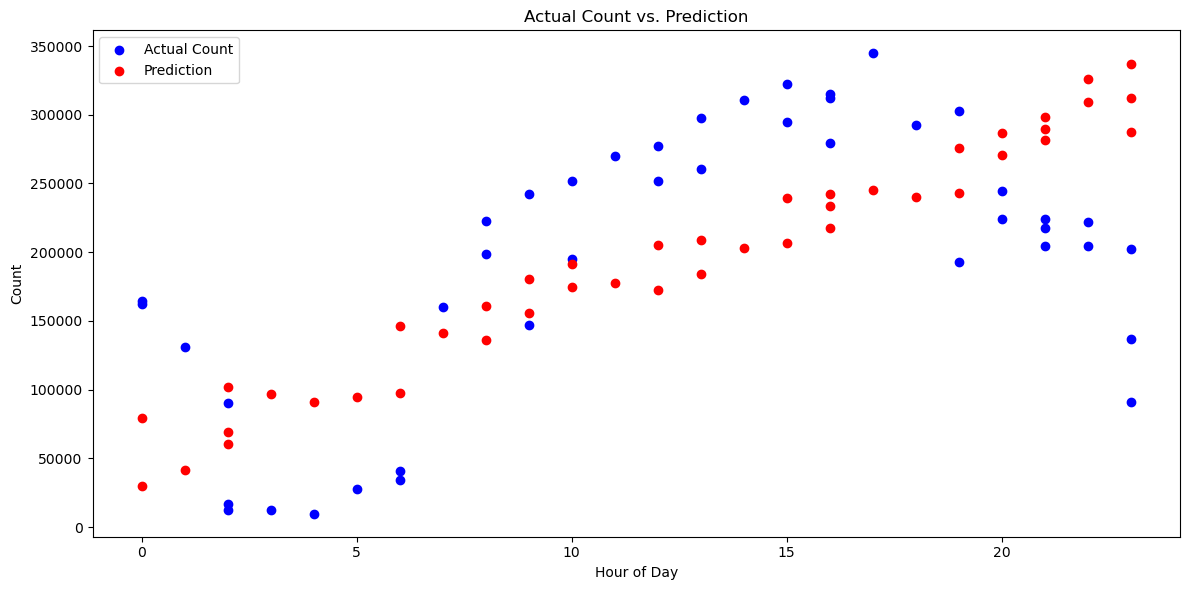

In [50]:
# Extract the columns from the DataFrame
hour_of_day = predictions.select("hour_of_day").rdd.flatMap(lambda x: x).collect()
day_of_week = predictions.select("day_of_week").rdd.flatMap(lambda x: x).collect()
count = predictions.select("count").rdd.flatMap(lambda x: x).collect()
prediction = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Plotting the actual values (count) and predictions (prediction)
plt.figure(figsize=(12, 6))

plt.scatter(hour_of_day, count, color='b', label='Actual Count')
plt.scatter(hour_of_day, prediction, color='r', label='Prediction')
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.title("Actual Count vs. Prediction")
plt.legend()

plt.tight_layout()
plt.show()